<a href="https://colab.research.google.com/github/435wldms/essa/blob/main/20230526_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 규제 선형 모델 - 릿지, 라쏘 엘라스틱넷

* RSS 값을 최소화하는 것만 고려하게 되면, 지나치게 학습데이터에 맞추게 되고 회귀 계수가 쉽게 커짐. -> 변동성이 심해져 테스트데이터에서 예측 성능 저하
* 비용 함수 목표 = Min(RSS(W) + alpha*|W|^2) -> RSS도 작고, W (회귀 계수)도 작게
* alpha를 0에서부터 지속적으로 값을 증가시키면 회귀 계수 값을 감소시키고 alpha가 매우 작으면 RSS 값을 감소시키게 됨.

* 규제 : 비용 함수에 alpha 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식
* L2 규제: W^2에 대해 페널티를 부여하는 방식(릿지)
* L1 규제: |W|에 대해 페널티 부여(라쏘)

**릿지 회귀**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(data, columns=['CRIM','ZN','INDUS','CHAS', 'NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함.
bostonDF['PRICE']= pd.DataFrame(target, columns=['MEDV'])
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1, inplace=False)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행.
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 folds의 개별 Negative MSE scores:',np.round(neg_mse_scores,3))
print(' 5 folds의 개별 RMSE scores:',np.round(rmse_scores,3))
print(' 5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 folds의 개별 Negative MSE scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
 5 folds의 평균 RMSE : 5.518


* 릿지의 alpha 값을 변화시키면서 RMSE와 회귀 계수 값의 변화 살펴 보기

In [ ]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0,0.1,1,10,100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas:
  ridge = Ridge(alpha=alpha)

  # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
  neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error',cv=5)
  avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
  print('alphs {0} 일 때 5 folds의 평균 RMSE: {1:.3f}'.format(alpha,avg_rmse))

alphs 0 일 때 5 folds의 평균 RMSE: 5.829
alphs 0.1 일 때 5 folds의 평균 RMSE: 5.788
alphs 1 일 때 5 folds의 평균 RMSE: 5.653
alphs 10 일 때 5 folds의 평균 RMSE: 5.518
alphs 100 일 때 5 folds의 평균 RMSE: 5.330


* alpha 값의 변화에 따른 피처의 회귀 계수 값을 가로 막대 그래프로 시각화

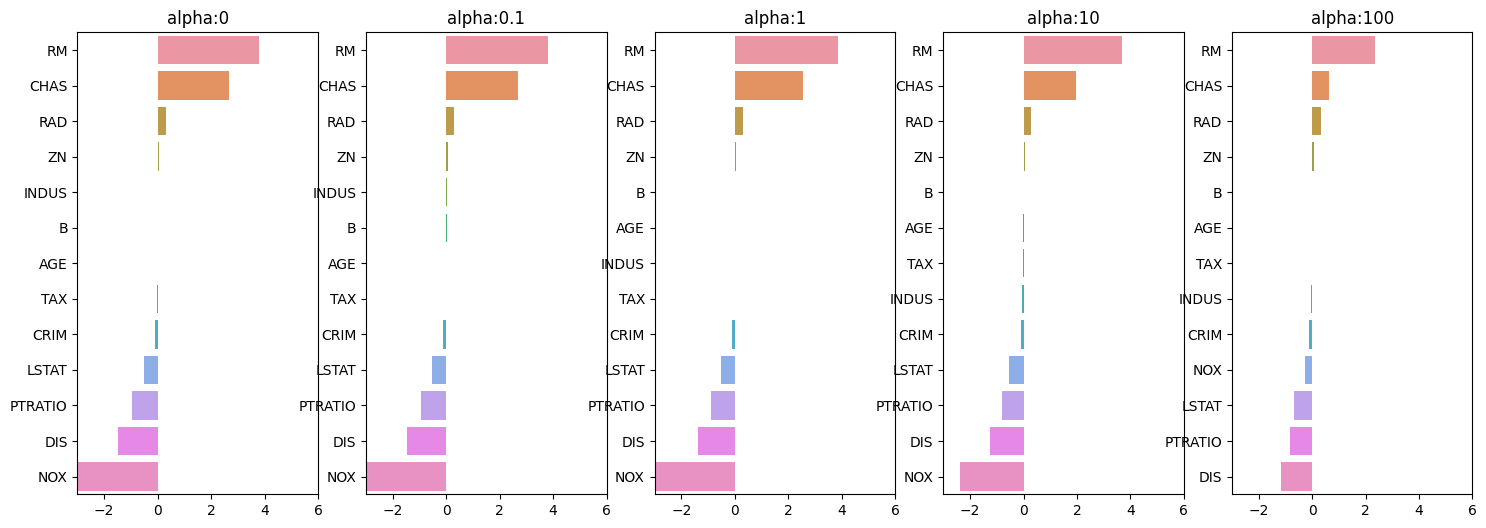

In [ ]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18,6),nrows=1,ncols=5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_data,y_target)
  
  # alpha에 따른 피처 별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
  coeff = pd.Series(data=ridge.coef_,index=X_data.columns)
  colname = 'alpha:'+str(alpha)
  coeff_df[colname] = coeff

  # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수 값이 높은 순으로 표현
  coeff = coeff.sort_values(ascending=False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3,6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

-> 결과 : alpha 값을 계속 증가시킬수록 회귀 계수 값이 지속적으로 작아짐 (특히 NOX가 폭이 큼)

In [ ]:
ridge_alphas = [0,0.1,1,10,100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


-> 결과 : alpha 값의 증가에 따라 회귀 계수가 지속적으로 작아지지만 0이 되지는 않음.

**라쏘 회귀**

* 회귀 계수의 크기를 감소시키는 L2 규제와 달리, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거
* 앞, 뒤로 동일하게 alpha 값을 변화시키면서 결과를 출력할 것이기 때문에 get_linear_reg_eval()이라는 함수 생성

In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
  coeff_df = pd.DataFrame()
  if verbose : print('#######',model_name,'#######')
  for param in params:
    if model_name == 'Ridge' : model = Ridge(alpha=param)
    elif model_name == 'Lasso' : model = Lasso(alpha=param)
    elif model_name == 'ElasticNet' : model = ElasticNet(alpha=param, l1_ratio=0.7)
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error',cv=5)
    avg_rmse = np.mean(-1*neg_mse_scores)
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param,avg_rmse))

    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추룰
    model.fit(X_data, y_target)

    # alpha에 따른 피처 별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
    coeff = pd.Series(data=model.coef_, index=X_data.columns)
    colname = 'alpha:'+str(param)
    coeff_df[colname] = coeff

  return coeff_df
# end of get_linear_regre_eval

In [ ]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07,0.1,0.5,1.3]
coeff_lasso_df = get_linear_reg_eval('Lasso',params = lasso_alphas,  X_data_n=X_data, y_target_n=y_target)

####### Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 34.895
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 34.830
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 34.634
alpha 1.3일 때 5 폴드 세트의 평균 RMSE: 36.233


In [ ]:
# 반환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+ str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1.3
RM,3.789725,3.703202,2.498212,0.018113
CHAS,1.434343,0.955190,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.255433
ZN,0.049059,0.049211,0.049544,0.048850
B,0.010248,0.010249,0.009469,0.007507
NOX,-0.000000,-0.000000,-0.000000,-0.000000
AGE,-0.011706,-0.010037,0.003604,0.031350
TAX,-0.014290,-0.014570,-0.015442,-0.014981
INDUS,-0.042120,-0.036619,-0.005253,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.051638


**엘라스틱넷 회귀**

* L2 규제와 L1 규제를 결합한 회귀 (RSS(W) + alpha2*|W|^2 + alpha1*|W|)
* 파라미터값 - alpha: a+b, l1_ratio: a / (a+b)
 -> l1_ration=0이면 L2규제와 l1_ratio=1이면 L1규제와 동일
 

In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07,0.1,0.5,1,3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

####### ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 33.673
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 33.318
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 31.618
alpha 1일 때 5 폴드 세트의 평균 RMSE: 33.090
alpha 3일 때 5 폴드 세트의 평균 RMSE: 39.025


In [ ]:
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


**선형 회귀 모델을 위한 데이터 변환**

* 선형 회귀 모델은 피처값과 타깃값의 분포가 정규 분포 형태를 매우 선호 -> 타깃 값이 정규 분포가 아니라 왜곡된 형태의 분포도일 경우 예측 성능에 부정적 영향을 미칠 가능성 높음. => 스케일링/정규화 작업 필요
* 스케일링. 정규화, 로그 변환이 있고 타깃 값의 경우는 일반적으로 로그 변환을 적용 (가장 성능 향상이 잘 됨)

In [ ]:
# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음.
def get_scaled_data(method='None',p_degree=None,input_data=None):
  if method == 'Standard':
    scaled_data = StandardScaler().fit_transform(input_data)
  elif method == 'MinMax':
    scaled_data = MinMaxScaler().fit_transform(input_data)
  elif method == 'Log':
    scaled_data = np.log1p(input_data)
  else:
    scaled_data = input_data

  if p_degree != None:
    scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
  
  return scaled_data

* Scale 거친 후 릿지 클래스의 alpha값을 변화시키면서 RMSE값이 어떻게 변하는지 살펴봄

In [ ]:
# Ridge의 alpha 값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출.
alphas = [0.1,1,10,100]

# 5개 방식으로 변환. 먼저 원본 그대로, 표준정규 분포, 표준정규 분포 + 다항식 특성
# 최대/최소 정규화, 최대/최소 정규화 + 다항식 특성, 로그 변환
scale_methods = [(None,None),('Standard',None),('Standard',2),
                ('MinMax',None),('MinMax', 2),('Log',None)]
for scale_method in scale_methods:
  X_data_scaled = get_scaled_data(method=scale_method[0],p_degree=scale_method[1],input_data=X_data)
  print('\n ## 변환 유형: {0},Polynomial Degree: {1}'.format(scale_method[0], scale_method[1]))
  get_linear_reg_eval('Ridge',params=alphas, X_data_n = X_data_scaled, y_target_n=y_target, verbose=False)

-> 결과: 정규분포, 최대/최솟값 정규화에서는 성능 개선이 없음, 2차 다항식 변환 시 성능 개선, 일반적으로 로그 변환이 좋은 개선이 있는 편

# 로지스틱회귀

* 선형 회귀 방식을 분류에 적용한 알고리즘
* 학습을 통해 시그모이드 함수 최적선을 찾고 이 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정
* 선형 회귀로 2 class 분류를 하면 정확도가 떨어지지만, S자 시그모이드 함수를 이용하면 더 정확하게 분류를 할 수 있음

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

* 표준 스케일링을 적용한 후 train, test로 나누기

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산이 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

* 로지스틱회귀를 이용한 학습, 예측, 정확도&ROC-AUC 구하기

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱회귀를 이용해 학습 및 예측 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# 정확도와 roc_auc 측정
print('accuracy: {0:.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {0:.3f}'.format(roc_auc_score(y_test, lr_preds)))

accuracy: 0.977
roc_auc: 0.972


* LinearRegression 주요 하이퍼파라미터 : penalty, C
* penalty(규제): L2(기본), L1
* C(규제 강도 조절): alpha 역수

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'penalty':['l2','l1'],
          'C': [0.01,0.1,1,5,10]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy',cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터 : {0}, 최적 평균 정확도 : {1:.3f}'.format(grid_clf.best_params_,grid_clf.best_score_))

최적 하이퍼 파라미터 : {'C': 1, 'penalty': 'l2'}, 최적 평균 정확도 : 0.975


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

# 회귀 트리

* 회귀 함수를 기반으로 하지 않고 트리를 기반으로 하는 회귀 방식
* 분류 트리와 유사하지만 예측 결정 값을 만드는 과정에서 차이가 있음 
 > 분류는 특정 클래스 레이블 값 결정 vs 회귀는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측 값 계산
* 결정 트리, 랜덤포레스트, GBM, XGBoost, LightGBM 등 모든 트리 기반의 알고리즘은 회귀에서도 적용 가능 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import numpy as np

# 보스턴 데이터 세트 로드
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(data, columns=['CRIM','ZN','INDUS','CHAS', 'NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함.
bostonDF['PRICE']= pd.DataFrame(target, columns=['MEDV'])
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1, inplace=False)

rf =RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores:',np.round(neg_mse_scores,2))
print(' 5 교차 검증의 개별 RMSE scores:',np.round(rmse_scores,2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores: [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423


* GBM, XGBoost, LightGBM의 Regressor를 모두 이용해 보스턴 주택 가격 예측
* get_model_cv_prediction() 함수를 만들어 교차 검증으로 평균 RMSE를 계산

In [ ]:
def get_model_cv_prediction(model, X_data, y_target):
  neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error',cv=5)
  rmse_scores = np.sqrt(-1 * neg_mse_scores)
  avg_rmse = np.mean(rmse_scores)
  print('#####', model.__class__.__name__,'#####')
  print(' 5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0,n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0,n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
  get_model_cv_prediction(model, X_data, y_target)

##### DecisionTreeRegressor #####
 5 교차 검증의 평균 RMSE : 5.978
##### RandomForestRegressor #####
 5 교차 검증의 평균 RMSE : 4.423
##### GradientBoostingRegressor #####
 5 교차 검증의 평균 RMSE : 4.269
##### XGBRegressor #####
 5 교차 검증의 평균 RMSE : 4.251
##### LGBMRegressor #####
 5 교차 검증의 평균 RMSE : 4.646


* feature_importances_ 확인 (coef_ 속성은 없음)

<Axes: >

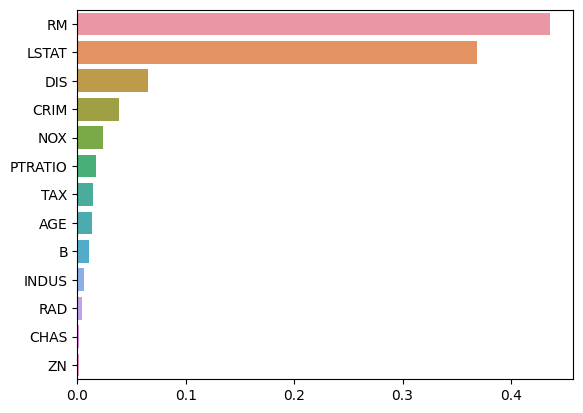

In [ ]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습합니다.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

* Price와 가장 밀접한 양의 상관관계를 가지는 RM 칼럼만 이용해 선형 회귀와 결정트리회귀로 PRICE 예측 회귀선 표현
* X축에 RM, Y축에 PRICE

* 100개만 샘플링

(100, 2)


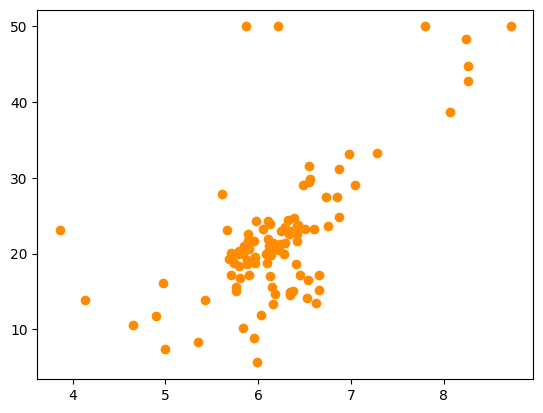

In [ ]:
bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100,random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2,7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5-8.5까지의 100개 데이터 세트로 생성.
X_test = np.arange(4.5,8.5,0.04).reshape(-1,1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행.
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

* 학습된 Regressor에서 예측한 Price 회귀선 그리기

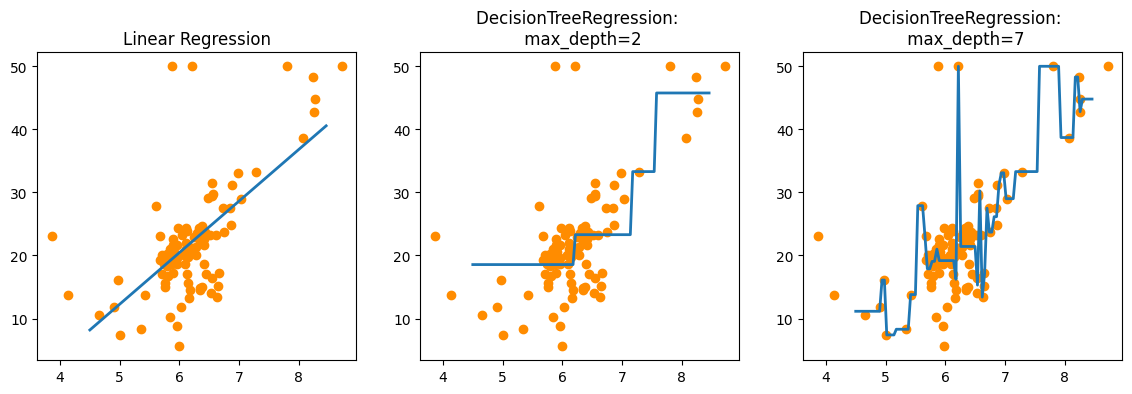

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(14,4),ncols=3)

# X축 값을 4.5 ~ 8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax1.plot(X_test, pred_lr, label='linear',linewidth=2)

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('DecisionTreeRegression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_rf2, label='max_depth:2',linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('DecisionTreeRegression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax3.plot(X_test, pred_rf7, label='max_depth:7',linewidth=2)

-> 결과: 선형 회귀는 직선, 회귀 트리는 계단 형태로 회귀선 만듦 (max_depth=7은 과적합 위험)